In [177]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

Авторегрессионная (AR-) модель (англ. autoregressive model) — модель временных рядов, в которой значения временного ряда в данный момент линейно зависят от предыдущих значений этого же ряда.

Сегодня мы с вами рассмотрим модели ARIMA - auto-regressive integrated moving average. Они часто применяются в предсказании временных рядов.

Она состоит из трех компонентов:
 - авторегрессивная. Отвечает за то, сколько прошлых значений будет использоваться. Параметр p определяет количество лагов, используюемых в модели. К примеру, AR(2) - модель будет основываться на двух предыдущих значениях
 
 - дифференциальная. Параметр d указывает на число  дифференцирований ряда. Используется для стабилизации ряда.
 
 - скользящего среднего. Параметр q определяет ошибку модели как комбинацию ошибок на прошлых шагах. 
 
Таким образом, дифференциальная, авторегрессионная и скользящего среднего компоненты составляют модель ARIMA без учета сезонности.

In [30]:
data = pd.Series.from_csv("monthly-australian-sales.csv", header=0)
data = data.astype(float)

In [31]:
data.head()

month
1980-01-01    15136.0
1980-02-01    16733.0
1980-03-01    20016.0
1980-04-01    17708.0
1980-05-01    18019.0
Name: sales, dtype: float64

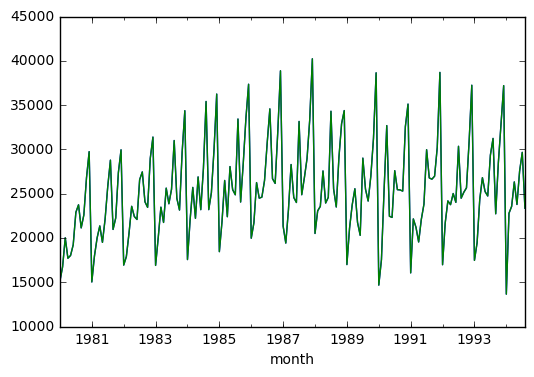

In [47]:
data.plot()
pyplot.show()

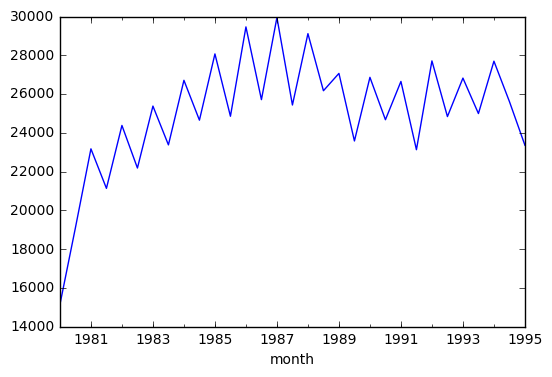

In [82]:
data.resample('6M', how='mean').plot()
pyplot.show()

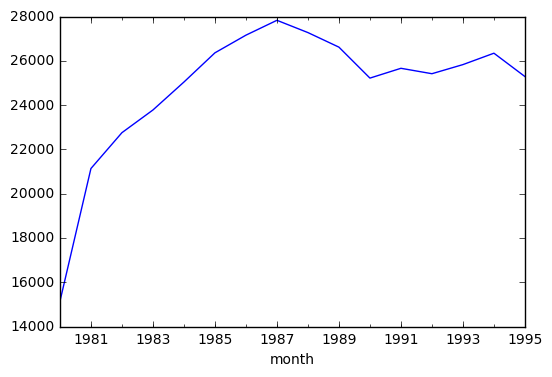

In [83]:
data.resample('12M', how='mean').plot()
pyplot.show()

In [48]:
print("from {0} to {1}".format(min(data.index), max(data.index)))


from 1980-01-01 00:00:00 to 1994-08-01 00:00:00


                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                  175
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -1749.221
Method:                       css-mle   S.D. of innovations           5289.824
Date:                Sat, 28 Apr 2018   AIC                           3512.441
Time:                        12:35:51   BIC                           3534.595
Sample:                    02-01-1980   HQIC                          3521.428
                         - 08-01-1994                                         
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const            52.1385    153.992      0.339      0.735      -249.681   353.958
ar.L1.D.sales    -0.6345      0.075     -8.415      0.000        -0.782    -0.487
ar.L2.D.sales    -0.6320      0.089     

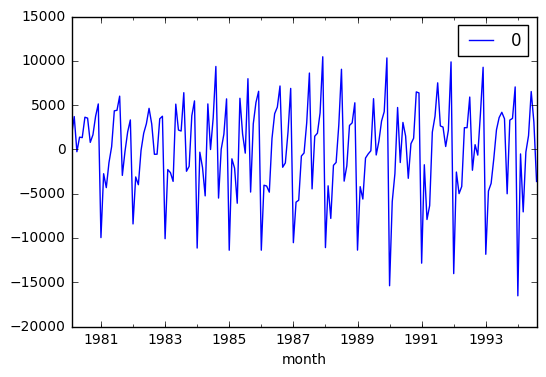

                  0
count    175.000000
mean      19.683276
std     5307.886222
min   -16532.704585
25%    -3027.439076
50%      787.981926
75%     3608.694627
max    10452.975039


In [40]:
model = ARIMA(data, order=(5,1,0)) 
model_fit = model.fit()
print(model_fit.summary())
print(model_fit.arparams)

residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
print(residuals.describe())

In [45]:
data['1994-08-01'] + model_fit.predict('1994-08-01')

1994-08-01    20679.274853
Freq: MS, dtype: float64

In [68]:
X = data
size = int(len(X)*0.97)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_absolute_error(test, predictions)
print('Test MSE: %.3f' % error)

predicted=20056.545334, expected=23565.000000
predicted=23396.039666, expected=26323.000000
predicted=25584.610266, expected=23779.000000
predicted=24605.313195, expected=27549.000000
predicted=26500.609060, expected=29660.000000
predicted=29137.947483, expected=23356.000000
Test MSE: 3354.342


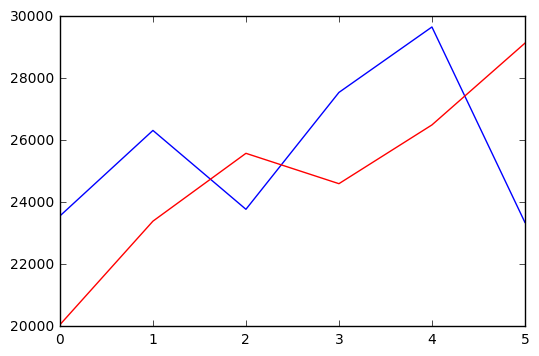

In [69]:
# plot
pyplot.plot(test.values)
pyplot.plot(predictions, color='red')
pyplot.show()

Но можно не сильно запариваться и предсказывать через линейную регрессию или случайные леса! 

Также можно вводить дополнительные фичи - кодировать день недели, какие-то инсайты пробрасывать.

In [160]:
data = pd.read_csv("monthly-australian-sales.csv", header=0)
data.head()

,month,sales
0,1980-01-01,15136
1,1980-02-01,16733
2,1980-03-01,20016
3,1980-04-01,17708
4,1980-05-01,18019


In [137]:
def map_season(month):
    # winter
    if month < 4:
        return 0
    # spring
    if month < 7:
        return 1
    # summer
    if month < 10:
        return 2
    # autumn
    return 3

def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [161]:
data["season"] = data['month'].map(lambda x: map_season(int(x[5:7])))
data["is_it_12_or_11"] = data['month'].map(lambda x: 1 if x[5:7] in ["11", "12"] else 0) 
data = data.set_index("month")
data.tail(10)

,sales,season,is_it_12_or_11
month,,,
1993-11-01,32857,3,1
1993-12-01,37198,3,1
1994-01-01,13652,0,0
1994-02-01,22784,0,0
1994-03-01,23565,0,0
1994-04-01,26323,1,0
1994-05-01,23779,1,0
1994-06-01,27549,1,0
1994-07-01,29660,2,0


In [171]:
boundary = len(data) * 95 // 100


data['mean_by_season'] = data['season'].map(code_mean(data[:boundary], 'season', "sales").get)
data['mean_by_11_12'] = data['is_it_12_or_11'].map(code_mean(data[:boundary], 'is_it_12_or_11', "sales").get)

train_x, train_y, test_x,  test_y = data[:boundary].drop("sales", axis=1), data[:boundary]["sales"], data[boundary:].drop("sales", axis=1), data[boundary:]["sales"]

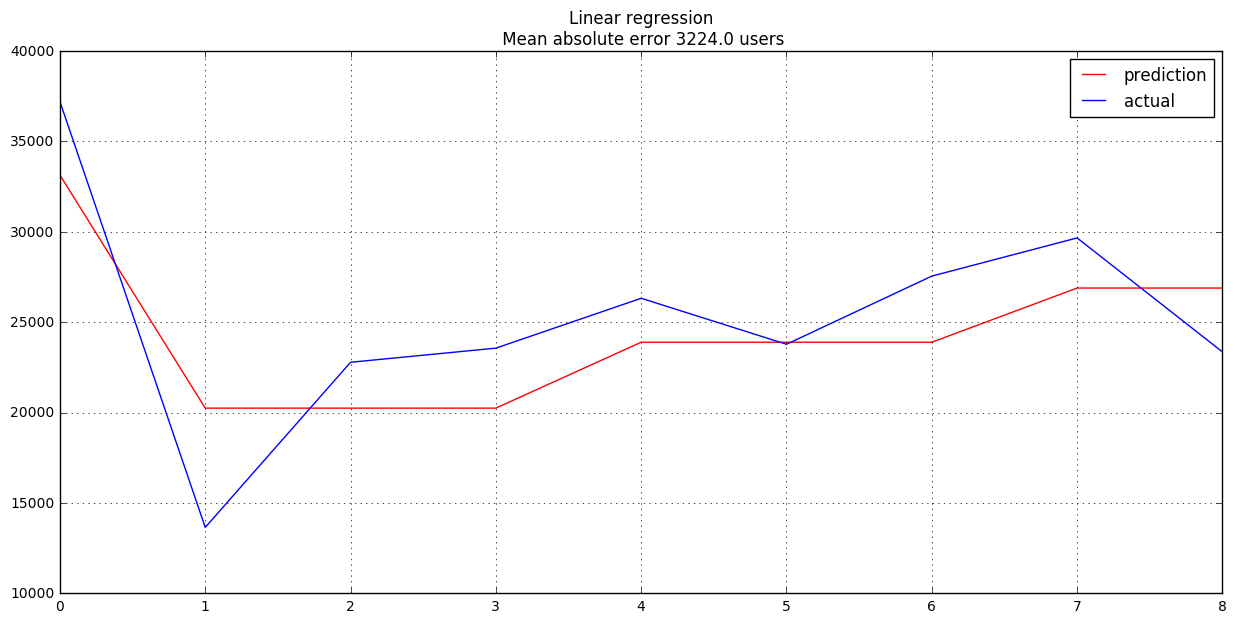

In [179]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(train_x, train_y)
prediction = lr.predict(test_x)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(test_y.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} users".format(round(mean_absolute_error(prediction, test_y))))
plt.grid(True);